# SETUP

In [34]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import networkx as nx

# CARGA DE DATOS

Esta sección tiene como objetivo **importar la información base del problema**, la cual se encuentra estructurada en archivos `.csv`. Cada archivo contiene un componente fundamental para la ejecución del modelo:

* **`clients.csv`**: contiene los datos de los centros de consumo o clientes, incluyendo su ubicación (latitud y longitud), su identificador único y su demanda en unidades o toneladas.
* **`depots.csv`**: contiene la ubicación del depósito principal desde donde inician y terminan los recorridos de los vehículos.
* **`vehicles.csv`**: contiene la información sobre cada vehículo de la flota, como su capacidad máxima de carga y, en algunos casos, su autonomía (capacidad máxima de recorrido).

Una vez cargados estos archivos en `DataFrames` de Pandas, se convierten en **listas de diccionarios**. Este formato es más conveniente para operar con estructuras algorítmicas como rutas, soluciones y evaluaciones personalizadas, ya que permite acceder a los datos de forma directa y flexible durante el algoritmo genético.


In [35]:
# Cargar los datos desde archivos CSV
clients_df = pd.read_csv('../data/I/clients.csv')   # Carga los datos de los clientes (ubicación, demanda, etc.)
depot_df = pd.read_csv('../data/I/depots.csv')      # Carga los datos del depósito principal
vehicles_df = pd.read_csv('../data/I/vehicles.csv') # Carga los datos de la flota de vehículos (capacidad, autonomía, etc.)

# Convertir los DataFrames en listas/diccionarios para facilitar su uso en el algoritmo
clients = clients_df.to_dict(orient='records')   # Lista de diccionarios, cada uno representa un cliente
depot = depot_df.iloc[0].to_dict()               # Extrae el primer (y único) depósito como diccionario
vehicles = vehicles_df.to_dict(orient='records') # Lista de diccionarios, cada uno representa un vehículo

# FUNCIONES DE DISTANCIA

Esta sección define las funciones necesarias para calcular las **distancias entre el depósito y los clientes**, así como entre los propios clientes. Esto es fundamental para estimar correctamente los **costos de transporte** y las rutas de distribución.

Se utiliza la fórmula de **Haversine**, que permite calcular la distancia más precisa entre dos puntos geográficos (latitud/longitud) sobre la superficie esférica de la Tierra, en lugar de usar la distancia euclidiana simple. Esto es especialmente importante cuando se trabaja con coordenadas reales.

Posteriormente, se construye una **matriz de distancias** (`dist_matrix`) que almacena las distancias entre todos los pares de nodos (clientes y depósito). Esta matriz se utilizará constantemente durante la evaluación de soluciones en el algoritmo genético.

In [36]:
# Función para calcular la distancia Haversine entre dos puntos geográficos
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radio de la Tierra en kilómetros
    # Convertir coordenadas de grados a radianes
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Diferencias de longitud y latitud
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Fórmula de Haversine
    a = (np.sin(dlat / 2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon / 2))**2
    return R * 2 * np.arcsin(np.sqrt(a))  # Distancia en kilómetros

# Función para generar la matriz de distancias entre todos los nodos (clientes + depósito)
def distance_matrix():
    all_nodes = [depot] + clients  # El primer nodo es el depósito, seguido por los clientes
    n = len(all_nodes)  # Número total de nodos
    dist = np.zeros((n, n))  # Inicializar matriz cuadrada de ceros de tamaño n x n

    # Llenar la matriz con las distancias entre cada par de nodos
    for i in range(n):
        for j in range(n):
            dist[i][j] = haversine(
                all_nodes[i]['Longitude'], all_nodes[i]['Latitude'],
                all_nodes[j]['Longitude'], all_nodes[j]['Latitude']
            )
    return dist  # Devuelve la matriz de distancias

# Crear la matriz de distancias
dist_matrix = distance_matrix()

# COSTOS Y PEAJES

En esta sección se definen los **parámetros económicos del modelo**, fundamentales para calcular el **costo total de cada ruta** asignada a los vehículos.

Se consideran tres tipos de costos:

1. **Costos por kilómetro recorrido**:

   * **Flete (`FLETE_COP_KM`)**: representa el costo de transporte por km.
   * **Mantenimiento (`MANTENIMIENTO_COP_KM`)**: representa el desgaste y reparación del vehículo por km.

2. **Costos asociados al peso**:

   * Un valor adicional (`ADICIONAL_PESO`) por tonelada transportada, aplicable solo si el trayecto incluye un peaje.

3. **Tarifas de peaje (`TARIFAS_PEAJE`)**:

   * Se modelan explícitamente por tramo (par de nodos origen–destino), y pueden tener un costo fijo y/o uno proporcional al peso transportado.

Estas funciones permiten consultar de forma eficiente los costos fijos y variables entre dos puntos durante la evaluación de cada ruta. Esta lógica se integrará más adelante en la función de `fitness` para obtener el **costo total por solución**.


In [37]:
# Costos por kilómetro
FLETE_COP_KM = 5000                # Costo por kilómetro recorrido (COP)
MANTENIMIENTO_COP_KM = 700         # Costo de mantenimiento por kilómetro (COP)

# Costos adicionales
ADICIONAL_PESO = 500               # Costo adicional por tonelada transportada si el trayecto tiene peaje

# Diccionario de tarifas fijas de peaje por trayecto (puede ampliarse con más rutas)
TARIFAS_PEAJE = {
    ("Depot", "C1"): 20000,        # Peaje entre el depósito y el cliente C1
    ("C1", "C2"): 10000            # Peaje entre cliente C1 y cliente C2
}

# Función para obtener la tarifa base de peaje entre dos nodos
def get_tarifa_base(i, j):
    return TARIFAS_PEAJE.get((i, j), 0)  # Devuelve el valor del peaje si existe, 0 en caso contrario

# Función para obtener la tarifa adicional por peso entre dos nodos (solo si hay peaje)
def get_tarifa_peso(i, j):
    if (i, j) in TARIFAS_PEAJE:
        return ADICIONAL_PESO        # Si hay peaje, se cobra un adicional por tonelada transportada
    return 0                         # Si no hay peaje, no hay costo adicional por peso

# ALGORITMO GENÉTICO

Esta sección implementa el núcleo del **algoritmo genético**, una técnica de optimización inspirada en los procesos evolutivos naturales. Su objetivo es encontrar una asignación eficiente de rutas para una flota de vehículos que satisfacen la demanda de múltiples clientes.

#### Estructura del algoritmo:

* **Hiperparámetros**:

  * `NUM_GENERATIONS`: número de generaciones a ejecutar.
  * `POP_SIZE`: número de soluciones (individuos) en cada generación.
  * `MUTATION_RATE`: probabilidad de que un individuo sufra una mutación.

#### Crear un individuo (solución):

Cada individuo representa una solución al problema: una asignación de clientes a vehículos que respeta la capacidad de carga. Para construirlo:

1. Se mezclan aleatoriamente los IDs de los clientes.
2. Se asignan uno a uno al primer vehículo que tenga suficiente capacidad disponible.
3. El resultado es una lista de rutas, donde cada sublista representa el recorrido de un vehículo.

Esta función se usará como parte de la inicialización de la población y durante los cruces.

In [38]:
# Hiperparámetros del algoritmo genético
NUM_GENERATIONS = 200      # Número de generaciones a ejecutar
POP_SIZE = 100             # Tamaño de la población por generación
MUTATION_RATE = 0.1        # Probabilidad de mutación por individuo

# === Crear un individuo (una solución) ===
def create_individual():
    clients_ids = [c['ClientID'] for c in clients]
    random.shuffle(clients_ids)  # Desordenar los clientes para obtener una solución aleatoria

    # Inicializar solución vacía: una lista de rutas (una por vehículo)
    solution = [[] for _ in vehicles]
    vehicle_caps = [v['Capacity'] for v in vehicles]  # Capacidad restante por vehículo
    demands = {c['ClientID']: c['Demand'] for c in clients}

    # Asignar cada cliente al primer vehículo que tenga suficiente capacidad
    for cid in clients_ids:
        for i, cap in enumerate(vehicle_caps):
            if demands[cid] <= cap:
                solution[i].append(cid)
                vehicle_caps[i] -= demands[cid]
                break
    return solution

# === Función de aptitud: calcular el costo total en COP de una solución ===
def fitness(individual):
    total_cost = 0
    id_index = {c['ClientID']: i+1 for i, c in enumerate(clients)}  # Mapear IDs a índices en la matriz
    demands = {c['ClientID']: c['Demand'] for c in clients}

    for k, route in enumerate(individual):
        if not route:
            continue

        weight = sum(demands[cid] for cid in route)  # Peso total transportado en esta ruta
        prev_node = "Depot"
        prev_index = 0  # Índice del depósito

        for cid in route:
            curr_node = f"C{cid}"
            curr_index = id_index[cid]
            dist = dist_matrix[prev_index][curr_index]

            # Costo base: distancia * (flete + mantenimiento)
            cost = dist * (FLETE_COP_KM + MANTENIMIENTO_COP_KM)
            cost += get_tarifa_base(prev_node, curr_node)  # Costo fijo de peaje si existe
            cost += weight * get_tarifa_peso(prev_node, curr_node)  # Costo por peso si aplica
            total_cost += cost

            # Actualizar nodo anterior
            prev_node = curr_node
            prev_index = curr_index

        # Volver al depósito desde el último cliente
        dist = dist_matrix[prev_index][0]
        cost = dist * (FLETE_COP_KM + MANTENIMIENTO_COP_KM)
        cost += get_tarifa_base(prev_node, "Depot")
        cost += weight * get_tarifa_peso(prev_node, "Depot")
        total_cost += cost

    return total_cost

# === Mutación: intercambiar aleatoriamente clientes entre dos vehículos ===
def mutate(individual):
    a, b = random.sample(range(len(individual)), 2)
    if individual[a] and individual[b]:
        i = random.randint(0, len(individual[a])-1)
        j = random.randint(0, len(individual[b])-1)
        individual[a][i], individual[b][j] = individual[b][j], individual[a][i]

# === Cruce: combinar dos padres en un hijo preservando factibilidad ===
def crossover(parent1, parent2):
    child = deepcopy(parent1)
    flat2 = [cid for route in parent2 for cid in route]  # Clientes en el segundo padre

    # Detectar clientes no usados aún en el hijo
    seen = set(cid for route in child for cid in route)
    unused = [cid for cid in flat2 if cid not in seen]

    vehicle_caps = [v['Capacity'] for v in vehicles]
    demands = {c['ClientID']: c['Demand'] for c in clients}

    # Insertar los clientes no usados respetando capacidad
    for cid in unused:
        for i, cap in enumerate(vehicle_caps):
            if demands[cid] <= cap:
                child[i].append(cid)
                vehicle_caps[i] -= demands[cid]
                break
    return child

# === Selección por torneo binario ===
def selection(population, fitnesses):
    selected = []
    for _ in range(len(population)):
        i, j = random.sample(range(len(population)), 2)
        winner = population[i] if fitnesses[i] < fitnesses[j] else population[j]
        selected.append(deepcopy(winner))
    return selected

# EJECUCIÓN

En esta sección se inicializa y ejecuta el algoritmo genético como proceso iterativo de mejora de soluciones.

## Inicialización:

* Se crea una **población inicial** de soluciones factibles, donde cada individuo representa una posible asignación de rutas a los vehículos.
* Estas soluciones son generadas con la función `create_individual()` que asegura que se respeten las capacidades de carga.

## Registro de la mejor solución:

* Se definen dos variables globales:

  * `best_solution`: guarda la mejor solución encontrada durante todas las generaciones.
  * `best_cost`: almacena el menor costo total asociado a esa solución.

Estas variables se irán actualizando durante cada iteración del ciclo evolutivo cuando se encuentre una solución superior.

In [39]:
# Inicializar la población inicial con soluciones aleatorias factibles
population = [create_individual() for _ in range(POP_SIZE)]

# Variables para guardar la mejor solución global y su costo
best_solution = None
best_cost = float('inf')

evolution = []
# Bucle principal del algoritmo genético: iterar por generaciones
for gen in tqdm(range(NUM_GENERATIONS)):  # tqdm agrega una barra de progreso visual
    # Evaluar el costo de cada individuo de la población
    fitnesses = [fitness(ind) for ind in population]

    # Buscar el mejor individuo de esta generación
    best_gen_idx = np.argmin(fitnesses)
    if fitnesses[best_gen_idx] < best_cost:
        best_cost = fitnesses[best_gen_idx]
        best_solution = deepcopy(population[best_gen_idx])  # Guardar la mejor solución hasta ahora

    # Selección por torneo binario: obtener padres para próxima generación
    selected = selection(population, fitnesses)
    new_population = []

    # Aplicar cruce y mutación para generar la nueva población
    for i in range(0, POP_SIZE, 2):
        p1, p2 = selected[i], selected[i+1]
        child1 = crossover(p1, p2)
        child2 = crossover(p2, p1)

        # Mutación con probabilidad definida
        if random.random() < MUTATION_RATE: mutate(child1)
        if random.random() < MUTATION_RATE: mutate(child2)

        # Agregar hijos a la nueva población
        new_population.extend([child1, child2])

    # Reemplazar población actual con la nueva
    population = new_population
    evolution.append(best_cost)

# Mostrar el mejor resultado encontrado después de todas las generaciones
print(f'\n→ Mejor costo total encontrado: {best_cost:.2f} COP')
for i, route in enumerate(best_solution):
    if route:
        print(f"Vehículo {i+1} → Ruta: {route}")

100%|██████████| 200/200 [00:00<00:00, 211.31it/s]


→ Mejor costo total encontrado: 998312.97 COP
Vehículo 1 → Ruta: [12, 15, 1, 22, 4, 2, 20, 23]
Vehículo 2 → Ruta: [19, 21, 7, 9, 11, 17, 24, 10, 16]
Vehículo 3 → Ruta: [5, 8, 18, 6, 13, 14, 3]


# GRAFICAR RUTAS

Esta sección define una función para **visualizar gráficamente las rutas generadas** por los vehículos desde el depósito hacia los clientes y de regreso.

Se utiliza la librería `networkx` para representar el recorrido de cada vehículo como un **grafo dirigido**, donde:

* Cada nodo representa un punto geográfico (el depósito o un cliente).
* Cada arco representa un trayecto en el orden de visita.
* Las flechas indican la dirección del recorrido.

Esto permite analizar visualmente aspectos como:

* La distribución geográfica de los clientes.
* Qué tan dispersas o concentradas están las rutas.
* El retorno al depósito.

La visualización incluye etiquetas, flechas direccionales, y un título personalizable. Es una herramienta clave para validar y comunicar los resultados del algoritmo.

C:\Users\dmbm\AppData\Local\Temp\ipykernel_56420\1624724446.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


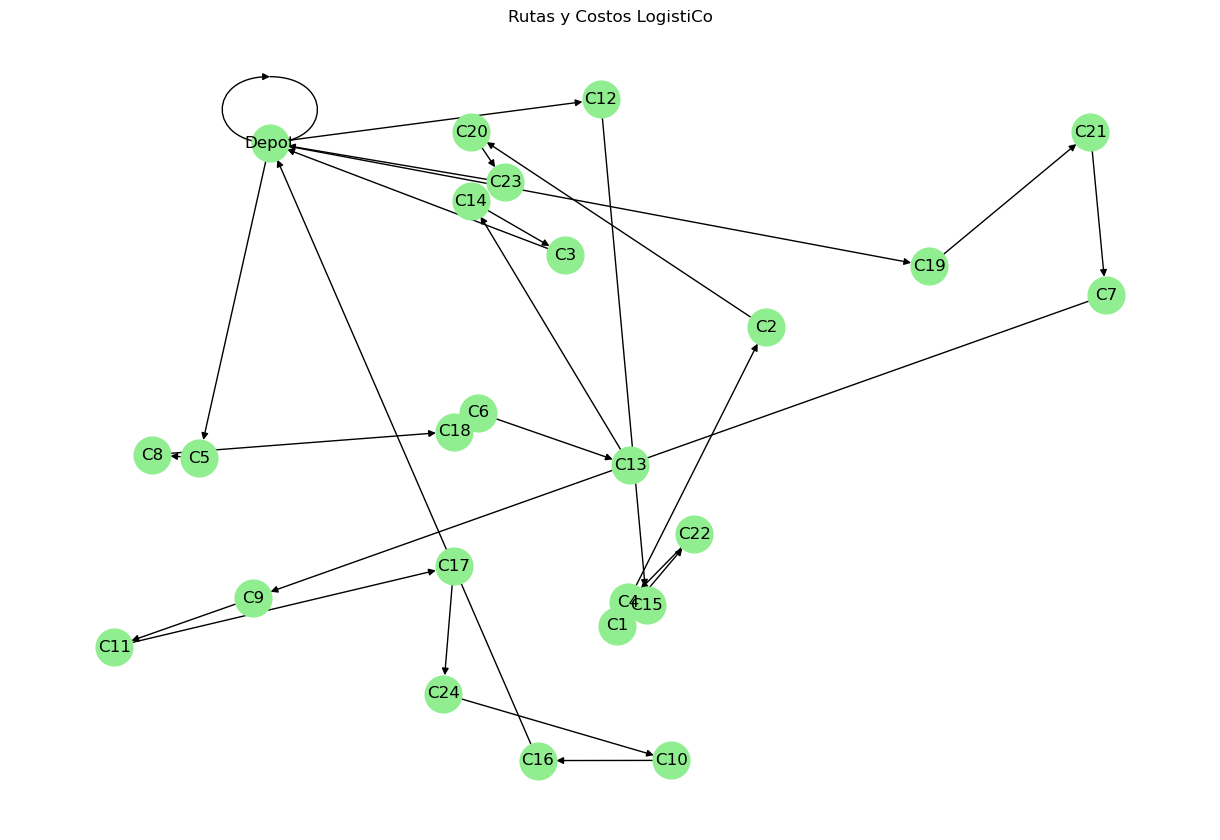

In [40]:
# === Función para visualizar rutas sobre el plano geográfico ===
def plot_routes(routes, depot_coords, client_coords, title="Rutas y Costos LogistiCo"):
    G = nx.DiGraph()  # Grafo dirigido para mostrar rutas con dirección

    # Agregar nodo del depósito con su posición
    G.add_node("Depot", pos=(depot_coords[0], depot_coords[1]))

    # Agregar nodos de los clientes con sus coordenadas
    for cid, coords in client_coords.items():
        G.add_node(f"C{cid}", pos=(coords[0], coords[1]))

    # Agregar arcos entre nodos según las rutas
    for route in routes:
        prev = "Depot"
        for cid in route:
            curr = f"C{cid}"
            G.add_edge(prev, curr)  # Desde nodo anterior al actual
            prev = curr
        G.add_edge(prev, "Depot")  # Volver al depósito al finalizar la ruta

    # Extraer posiciones para dibujar
    pos = nx.get_node_attributes(G, 'pos')

    # Dibujar el grafo con las rutas
    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=700,
        node_color="lightgreen",
        edge_color="black",
        arrows=True
    )
    plt.title(title)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Preparar datos de entrada y graficar la mejor solución ===
depot_coords = (depot['Longitude'], depot['Latitude'])  # Coordenadas del depósito
client_coords = {c['ClientID']: (c['Longitude'], c['Latitude']) for c in clients}  # Coordenadas por cliente

# Graficar las rutas encontradas por el mejor individuo
plot_routes(best_solution, depot_coords, client_coords)

# EXPORTAR A CSV

Una vez encontrada la mejor solución por el algoritmo genético, esta sección se encarga de **estructurar y guardar los resultados en un archivo `.csv`** llamado `solution_output.csv`.

Cada fila del archivo representa el resultado de la asignación de una ruta a un vehículo e incluye los siguientes campos:

* **VehicleId**: identificador del vehículo.
* **LoadCap / InitialLoad**: capacidad máxima y carga utilizada.
* **FuelCap / InitialFuel**: autonomía, si está disponible.
* **RouteSequence**: orden de visita entre municipios (incluyendo retorno al depósito).
* **Municipalities**: número de clientes atendidos.
* **DemandSatisfied**: suma de la demanda cubierta en esa ruta.
* **Distance / Time**: distancia recorrida y tiempo estimado.
* **TotalCost**: costo total asociado a esa ruta (COP).

Este archivo permite analizar las soluciones obtenidas, compartir los resultados y usarlos como entrada para otros análisis, simulaciones o reportes institucionales.

In [41]:
# === Generación de archivo CSV con la solución final ===

output_rows = []

# Mapas auxiliares: índice en la matriz de distancias y demandas por cliente
id_index = {c['ClientID']: i+1 for i, c in enumerate(clients)}  # Índice en matriz (depósito es 0)
demands = {c['ClientID']: c['Demand'] for c in clients}         # Mapeo de demandas por cliente

# Recorrer cada ruta asignada a los vehículos en la mejor solución
for idx, route in enumerate(best_solution):
    if not route:
        continue  # Saltar vehículos sin ruta

    vehicle = vehicles[idx]  # Datos del vehículo actual

    # Crear nombre simbólico de la ruta (por ejemplo: PTO - MUN01 - MUN05 - PTO)
    route_names = ["PTO"] + [f"MUN{cid:02d}" for cid in route] + ["PTO"]
    route_str = " - ".join(route_names)

    # Obtener demandas y distancias de la ruta
    demands_list = [demands[cid] for cid in route]
    total_demand = sum(demands_list)

    # Calcular distancia total recorrida por el vehículo (ida y regreso)
    total_distance = 0
    prev = 0  # Índice del depósito
    for cid in route:
        curr = id_index[cid]
        total_distance += dist_matrix[prev][curr]
        prev = curr
    total_distance += dist_matrix[prev][0]  # Regreso al depósito

    # Calcular tiempo estimado (suponiendo 60 km/h constantes)
    total_time = total_distance / 60

    # Evaluar el costo total usando la función de aptitud (en COP)
    total_cost = fitness([route])

    # Agregar datos al resultado
    output_rows.append({
        "VehicleId": f"CAM{idx+1:03d}",                     # ID del vehículo
        "LoadCap": vehicle['Capacity'],                     # Capacidad de carga
        "FuelCap": vehicle.get('Range', 'N/A'),             # Capacidad de combustible (si aplica)
        "RouteSequence": route_str,                         # Ruta textual
        "Municipalities": len(route),                       # Número de municipios atendidos
        "DemandSatisfied": total_demand,                    # Suma total de la demanda satisfecha
        "InitialLoad": total_demand,                        # Carga inicial (igual a la total)
        "InitialFuel": vehicle.get('Range', 'N/A'),         # Combustible inicial
        "Distance": round(total_distance, 2),               # Distancia total recorrida
        "Time": round(total_time, 2),                       # Tiempo estimado (horas)
        "TotalCost": round(total_cost, 2)                   # Costo total de la ruta en COP
    })

# Crear DataFrame y guardar en archivo CSV
output_df = pd.DataFrame(output_rows)
output_df.to_csv("solution_output.csv", index=False)

print("\nArchivo CSV generado como 'solution_output.csv'")



Archivo CSV generado como 'solution_output.csv'


# ANÁLISIS DE ESCALABILIDAD DEL ALGORITMO GENÉTICO

En esta sección se realiza una simulación para evaluar la **escalabilidad del algoritmo genético** al aumentar progresivamente el número de clientes.

El objetivo es observar cómo se comporta el algoritmo en términos de:

* **Tiempo de ejecución**: cuánto tarda el algoritmo en encontrar una solución para diferentes tamaños de instancia.
* **Calidad de la solución**: cómo varía el costo total encontrado a medida que el número de clientes crece.

## ¿Cómo se realiza?

* Se parte de un conjunto base de clientes reales (`clients.csv`).
* Si el número de clientes deseado supera el tamaño original, se simulan nuevos clientes **duplicando y desplazando aleatoriamente** los existentes.
* Para cada tamaño (`10, 20, 30, 40, 50` clientes), se:

  1. Genera una nueva instancia.
  2. Ejecuta el algoritmo genético completo.
  3. Registra el **mejor costo encontrado** y el **tiempo total de ejecución**.

## Resultados:

Dos gráficos resumen los resultados:

* **Tiempo vs número de clientes**: muestra cómo escala el algoritmo en términos computacionales.
* **Costo vs número de clientes**: permite observar si la calidad de las soluciones se mantiene o deteriora.

Este análisis es fundamental para justificar la viabilidad del algoritmo en casos reales de mayor escala.


Ejecutando con 10 clientes...

Ejecutando con 20 clientes...
Número de clientes (30) excede los datos disponibles. Simulando clientes adicionales...

Ejecutando con 30 clientes...
Número de clientes (40) excede los datos disponibles. Simulando clientes adicionales...

Ejecutando con 40 clientes...
Número de clientes (50) excede los datos disponibles. Simulando clientes adicionales...

Ejecutando con 50 clientes...


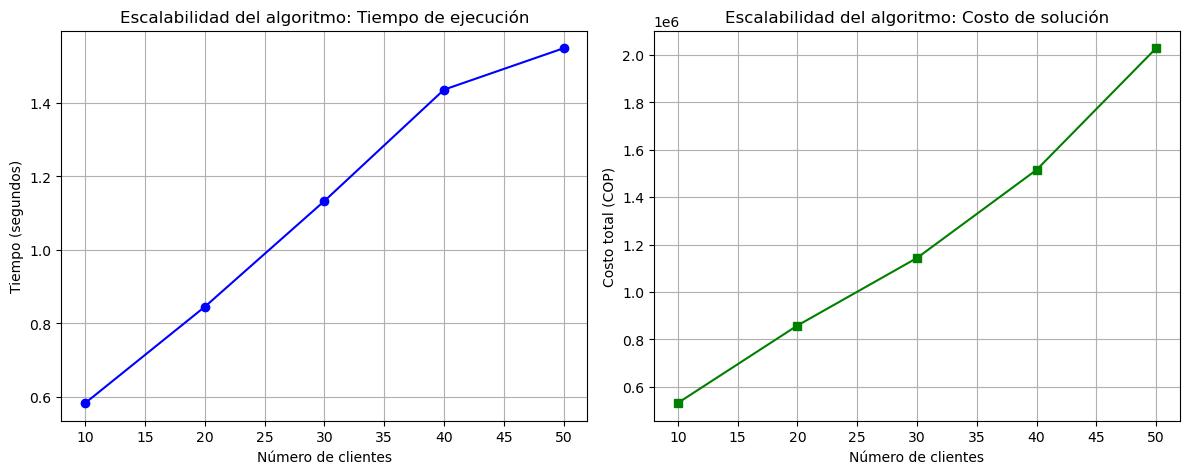

In [42]:
# === Imports necesarios ===
import time
import matplotlib.pyplot as plt
import numpy as np
import random
from copy import deepcopy

# Tamaños de instancias a probar (número de clientes)
client_counts = [10, 20, 30, 40, 50]
exec_times = []            # Lista para guardar tiempos de ejecución
best_costs = []            # Lista para guardar los mejores costos encontrados
used_client_counts = []    # Lista para registrar cuántos clientes se usaron en cada prueba

# Copia original del conjunto de clientes
original_clients = clients_df.copy()

# === Función para simular más clientes duplicando existentes con ligera variación ===
def expand_clients(df, target_size):
    df = df.copy()
    while len(df) < target_size:
        new_client = df.sample(1).copy()
        new_client.index = [len(df)]
        if 'x' in new_client.columns and 'y' in new_client.columns:
            new_client['x'] += np.random.uniform(-0.01, 0.01)
            new_client['y'] += np.random.uniform(-0.01, 0.01)
        df = pd.concat([df, new_client], ignore_index=True)
    return df

# === Bucle de pruebas por tamaño de instancia ===

for n_clients in client_counts:
    if n_clients > len(original_clients):
        print(f"Número de clientes ({n_clients}) excede los datos disponibles. Simulando clientes adicionales...")
        clients_df = expand_clients(original_clients, n_clients)
    else:
        clients_df = original_clients.iloc[:n_clients].copy()

    print(f"\nEjecutando con {n_clients} clientes...")

    # Convertir DataFrame de clientes en lista de diccionarios
    clients = clients_df.to_dict(orient='records')

    # Recalcular la matriz de distancias para la instancia actual
    dist_matrix = distance_matrix()

    # === Ejecutar algoritmo genético ===
    population = [create_individual() for _ in range(POP_SIZE)]  # Población inicial
    best_solution = None
    best_cost = float('inf')

    start = time.time()  # Medir tiempo de ejecución
    for gen in range(NUM_GENERATIONS):
        fitnesses = [fitness(ind) for ind in population]
        best_gen_idx = np.argmin(fitnesses)
        if fitnesses[best_gen_idx] < best_cost:
            best_cost = fitnesses[best_gen_idx]
            best_solution = deepcopy(population[best_gen_idx])
        selected = selection(population, fitnesses)
        new_population = []
        for i in range(0, POP_SIZE, 2):
            p1, p2 = selected[i], selected[i + 1]
            child1 = crossover(p1, p2)
            child2 = crossover(p2, p1)
            if random.random() < MUTATION_RATE: mutate(child1)
            if random.random() < MUTATION_RATE: mutate(child2)
            new_population.extend([child1, child2])
        population = new_population
    end = time.time()

    # Guardar resultados de esta corrida
    exec_times.append(end - start)
    best_costs.append(best_cost)
    used_client_counts.append(n_clients)

# === Visualización de resultados de escalabilidad ===
plt.figure(figsize=(12, 5))

# Subplot 1: tiempo de ejecución por número de clientes
plt.subplot(1, 2, 1)
plt.plot(used_client_counts, exec_times, marker='o', color='blue')
plt.title("Escalabilidad del algoritmo: Tiempo de ejecución")
plt.xlabel("Número de clientes")
plt.ylabel("Tiempo (segundos)")
plt.grid(True)

# Subplot 2: costo total por número de clientes
plt.subplot(1, 2, 2)
plt.plot(used_client_counts, best_costs, marker='s', color='green')
plt.title("Escalabilidad del algoritmo: Costo de solución")
plt.xlabel("Número de clientes")
plt.ylabel("Costo total (COP)")
plt.grid(True)

# Mostrar ambos gráficos
plt.tight_layout()
plt.show()

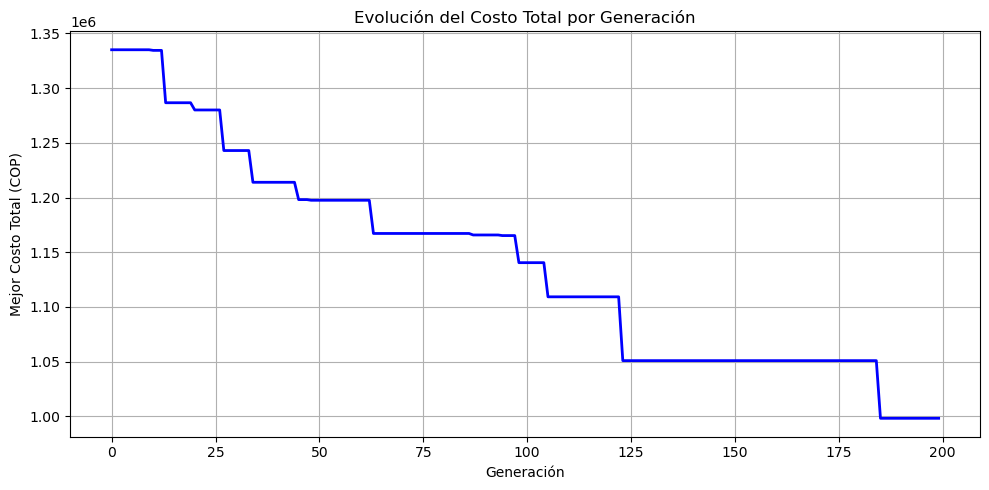

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(evolution)), evolution, color='blue', linewidth=2)
plt.title("Evolución del Costo Total por Generación")
plt.xlabel("Generación")
plt.ylabel("Mejor Costo Total (COP)")
plt.grid(True)
plt.tight_layout()
plt.show()
